# Split Pipelines

Split pipelines allow you to **divide a dataframe into subsets**, apply different transformations to each subset, and then **merge the results back together**.

This is useful when:
- Different data segments require different processing logic
- You want to apply conditional transformations based on data values
- You need to process data in parallel branches (especially useful in Spark)

**What you'll learn:**
1. Creating a basic split pipeline
2. Writing split functions
3. All split pipeline options explained
4. Common patterns and use cases

In [1]:
import polars as pl

from nebula import TransformerPipeline
from nebula.transformers import (
    AddLiterals,
    AssertNotEmpty,
    Cast,
    DropColumns,
    Filter,
    RenameColumns,
    SelectColumns,
    When,
    WithColumns,
)

## Sample Data

We'll work with customer orders that need different processing based on order value.

In [2]:
orders_df = pl.DataFrame({
    "order_id": [1, 2, 3, 4, 5, 6, 7, 8],
    "customer": ["Alice", "Bob", "Charlie", "Diana", "Eve", "Frank", "Grace", "Henry"],
    "amount": [50.0, 250.0, 75.0, 1200.0, 30.0, 500.0, 800.0, 45.0],
    "category": ["electronics", "furniture", "electronics", "furniture", "books", "electronics", "furniture", "books"],
})

orders_df

order_id,customer,amount,category
i64,str,f64,str
1,"""Alice""",50.0,"""electronics"""
2,"""Bob""",250.0,"""furniture"""
3,"""Charlie""",75.0,"""electronics"""
4,"""Diana""",1200.0,"""furniture"""
5,"""Eve""",30.0,"""books"""
6,"""Frank""",500.0,"""electronics"""
7,"""Grace""",800.0,"""furniture"""
8,"""Henry""",45.0,"""books"""


## 1. Basic Split Pipeline

A split pipeline requires:
1. **A dictionary** mapping split names to transformer lists
2. **A split function** that divides the dataframe and returns a dict with matching keys

In [4]:
def split_by_order_value(df):
    """Split orders into standard (<100) and premium (>=100) segments."""
    return {
        "standard": df.filter(pl.col("amount") < 100),
        "premium": df.filter(pl.col("amount") >= 100),
    }


# Define different transformations for each segment
standard_transforms = [
    AddLiterals(data=[{"alias": "tier", "value": "standard"}]),
    AddLiterals(data=[{"alias": "discount_rate", "value": 0.0}]),
]

premium_transforms = [
    AddLiterals(data=[{"alias": "tier", "value": "premium"}]),
    AddLiterals(data=[{"alias": "discount_rate", "value": 0.1}]),  # 10% discount for premium
]

# Create the split pipeline
split_pipe = TransformerPipeline(
    {
        "standard": standard_transforms,
        "premium": premium_transforms,
    },
    split_function=split_by_order_value,
    name="Order Value Split",
)

split_pipe.show(add_params=True)

*** Order Value Split *** (4 transformations)
------ SPLIT ------ (function: split_by_order_value)
**SPLIT <<< premium >>> (2 transformations):
     - AddLiterals -> PARAMS: data=[{'alias': 'tier', 'value': 'premium'}]
     - AddLiterals -> PARAMS: data=[{'alias': 'discount_rate', 'value': 0.1}]
**SPLIT <<< standard >>> (2 transformations):
     - AddLiterals -> PARAMS: data=[{'alias': 'tier', 'value': 'standard'}]
     - AddLiterals -> PARAMS: data=[{'alias': 'discount_rate', 'value': 0.0}]
<<< Append DFs >>>


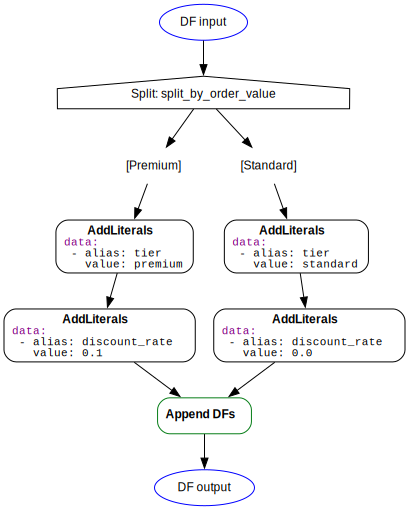

In [5]:
split_pipe.plot(add_params=True)

In [6]:
result = split_pipe.run(orders_df)
result.sort("order_id")

2025-12-26 00:20:08,550 | [INFO]: Starting pipeline 'Order Value Split' 
2025-12-26 00:20:08,552 | [INFO]: Entering split 
2025-12-26 00:20:08,557 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:08,572 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:08,573 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:08,576 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:08,577 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:08,578 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:08,579 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:08,581 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:08,586 | [INFO]: Pipeline 'Order Value Split' completed in 0.0s 


order_id,customer,amount,category,tier,discount_rate
i64,str,f64,str,str,f64
1,"""Alice""",50.0,"""electronics""","""standard""",0.0
2,"""Bob""",250.0,"""furniture""","""premium""",0.1
3,"""Charlie""",75.0,"""electronics""","""standard""",0.0
4,"""Diana""",1200.0,"""furniture""","""premium""",0.1
5,"""Eve""",30.0,"""books""","""standard""",0.0
6,"""Frank""",500.0,"""electronics""","""premium""",0.1
7,"""Grace""",800.0,"""furniture""","""premium""",0.1
8,"""Henry""",45.0,"""books""","""standard""",0.0


## 2. Split Pipeline Options

Split pipelines support many options for fine-grained control. Here's a complete reference:

| Option | Description |
|--------|-------------|
| `split_function` | Function that splits df into dict of subsets |
| `split_order` | List defining execution order of splits |
| `split_apply_after_splitting` | Transformers applied to ALL splits immediately after splitting |
| `split_apply_before_appending` | Transformers applied to ALL splits just before merging |
| `splits_no_merge` | Set of split names that won't be merged back (dead-ends) |
| `splits_skip_if_empty` | Set of split names to skip if their subset is empty |
| `cast_subsets_to_input_schema` | Cast all subsets to input schema before merging |
| `allow_missing_columns` | Allow splits to have different columns (fills with null) |
| `repartition_output_to_original` | Spark: repartition after merge to original partition count |
| `coalesce_output_to_original` | Spark: coalesce after merge to original partition count |

### 2.1 `split_order` — Control Execution Order

By default, splits execute in alphabetical order. Use `split_order` to specify a different order.

In [7]:
pipe_ordered = TransformerPipeline(
    {
        "alpha": [AddLiterals(data=[{"alias": "processed_order", "value": 1}])],
        "beta": [AddLiterals(data=[{"alias": "processed_order", "value": 2}])],
        "gamma": [AddLiterals(data=[{"alias": "processed_order", "value": 3}])],
    },
    split_function=lambda df: {
        "alpha": df.filter(pl.col("amount") < 100),
        "beta": df.filter((pl.col("amount") >= 100) & (pl.col("amount") < 500)),
        "gamma": df.filter(pl.col("amount") >= 500),
    },
    split_order=["gamma", "beta", "alpha"],  # Process high-value first
    name="Ordered Split",
)

pipe_ordered.show()

*** Ordered Split *** (3 transformations)
------ SPLIT ------ (function: <lambda>)
**SPLIT <<< gamma >>> (1 transformation):
     - AddLiterals
**SPLIT <<< beta >>> (1 transformation):
     - AddLiterals
**SPLIT <<< alpha >>> (1 transformation):
     - AddLiterals
<<< Append DFs >>>


### 2.2 `split_apply_after_splitting` — Common Pre-Processing

Apply transformers to ALL splits right after the split occurs. Useful for common setup.

In [8]:
def log_split_info(df):
    """Log info about each split (runs for each split)."""
    print(f"  → Processing split with {len(df)} rows")
    return df


pipe_with_pre = TransformerPipeline(
    {
        "standard": [AddLiterals(data=[{"alias": "tier", "value": "standard"}])],
        "premium": [AddLiterals(data=[{"alias": "tier", "value": "premium"}])],
    },
    split_function=split_by_order_value,
    split_apply_after_splitting=[
        log_split_info,  # Runs for BOTH standard and premium
        AssertNotEmpty(),  # Validate each split has data
    ],
    name="With Pre-Processing",
)

pipe_with_pre.show()

*** With Pre-Processing *** (6 transformations)
------ SPLIT ------ (function: split_by_order_value)
**SPLIT <<< premium >>> (3 transformations):
     - log_split_info
     - AssertNotEmpty
     - AddLiterals
**SPLIT <<< standard >>> (3 transformations):
     - log_split_info
     - AssertNotEmpty
     - AddLiterals
<<< Append DFs >>>


In [9]:
pipe_with_pre.run(orders_df)

2025-12-26 00:20:17,791 | [INFO]: Starting pipeline 'With Pre-Processing' 
2025-12-26 00:20:17,794 | [INFO]: Entering split 
2025-12-26 00:20:17,796 | [INFO]: Running 'log_split_info' ... 
2025-12-26 00:20:17,798 | [INFO]: Completed 'log_split_info' in 0.0s 
2025-12-26 00:20:17,799 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-26 00:20:17,801 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-26 00:20:17,803 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:17,805 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:17,805 | [INFO]: Running 'log_split_info' ... 
2025-12-26 00:20:17,805 | [INFO]: Completed 'log_split_info' in 0.0s 
2025-12-26 00:20:17,805 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-26 00:20:17,805 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-26 00:20:17,805 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:17,805 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:17,805 | [INFO]: Pipeline 'With Pre-Processing' completed in 0.0s 

  → Processing split with 4 rows
  → Processing split with 4 rows


order_id,customer,amount,category,tier
i64,str,f64,str,str
2,"""Bob""",250.0,"""furniture""","""premium"""
4,"""Diana""",1200.0,"""furniture""","""premium"""
6,"""Frank""",500.0,"""electronics""","""premium"""
7,"""Grace""",800.0,"""furniture""","""premium"""
1,"""Alice""",50.0,"""electronics""","""standard"""
3,"""Charlie""",75.0,"""electronics""","""standard"""
5,"""Eve""",30.0,"""books""","""standard"""
8,"""Henry""",45.0,"""books""","""standard"""


### 2.3 `split_apply_before_appending` — Common Post-Processing

Apply transformers to ALL splits just before they're merged back together.

In [10]:
pipe_with_post = TransformerPipeline(
    {
        "standard": [AddLiterals(data=[{"alias": "tier", "value": "standard"}])],
        "premium": [AddLiterals(data=[{"alias": "tier", "value": "premium"}])],
    },
    split_function=split_by_order_value,
    split_apply_before_appending=[
        # Add processing timestamp to ALL splits before merge
        AddLiterals(data=[{"alias": "processed", "value": True}]),
    ],
    name="With Post-Processing",
)

pipe_with_post.run(orders_df).sort("order_id")

2025-12-26 00:20:24,823 | [INFO]: Starting pipeline 'With Post-Processing' 
2025-12-26 00:20:24,825 | [INFO]: Entering split 
2025-12-26 00:20:24,828 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:24,831 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:24,831 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:24,831 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:24,831 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:24,831 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:24,831 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:24,831 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:24,844 | [INFO]: Pipeline 'With Post-Processing' completed in 0.0s 


order_id,customer,amount,category,tier,processed
i64,str,f64,str,str,bool
1,"""Alice""",50.0,"""electronics""","""standard""",true
2,"""Bob""",250.0,"""furniture""","""premium""",true
3,"""Charlie""",75.0,"""electronics""","""standard""",true
4,"""Diana""",1200.0,"""furniture""","""premium""",true
5,"""Eve""",30.0,"""books""","""standard""",true
6,"""Frank""",500.0,"""electronics""","""premium""",true
7,"""Grace""",800.0,"""furniture""","""premium""",true
8,"""Henry""",45.0,"""books""","""standard""",true


### 2.4 `splits_no_merge` — Dead-End Splits

Sometimes you want to process a subset but NOT include it in the final output (e.g., archiving, logging, or side-effects).

In [11]:
from nebula.storage import nebula_storage as ns


def store_for_audit(df):
    """Store data for audit purposes (side effect)."""
    ns.set("audit_premium_orders", df)
    print(f"  📋 Stored {len(df)} premium orders for audit")
    return df


pipe_dead_end = TransformerPipeline(
    {
        "standard": [AddLiterals(data=[{"alias": "tier", "value": "standard"}])],
        "premium_audit": [store_for_audit],  # This split won't be in output
    },
    split_function=split_by_order_value,
    splits_no_merge={"premium_audit"},  # Exclude from final merge
    name="With Dead-End Split",
)

# Note: split function keys must match pipeline keys
def split_with_audit(df):
    return {
        "standard": df.filter(pl.col("amount") < 100),
        "premium_audit": df.filter(pl.col("amount") >= 100),
    }

pipe_dead_end = TransformerPipeline(
    {
        "standard": [AddLiterals(data=[{"alias": "tier", "value": "standard"}])],
        "premium_audit": [store_for_audit],
    },
    split_function=split_with_audit,
    splits_no_merge={"premium_audit"},
    name="With Dead-End",
)

result = pipe_dead_end.run(orders_df)
print(f"\nOutput only contains standard orders ({len(result)} rows):")
result

2025-12-26 00:20:26,292 | [INFO]: Starting pipeline 'With Dead-End' 
2025-12-26 00:20:26,292 | [INFO]: Entering split: {'splits_no_merge': {'premium_audit'}} 
2025-12-26 00:20:26,307 | [INFO]: Running 'store_for_audit' ... 
2025-12-26 00:20:26,307 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "audit_premium_orders". 
2025-12-26 00:20:26,309 | [INFO]: Completed 'store_for_audit' in 0.0s 
2025-12-26 00:20:26,309 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:26,313 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:26,314 | [INFO]: Pipeline 'With Dead-End' completed in 0.0s 


  📋 Stored 4 premium orders for audit

Output only contains standard orders (4 rows):


order_id,customer,amount,category,tier
i64,str,f64,str,str
1,"""Alice""",50.0,"""electronics""","""standard"""
3,"""Charlie""",75.0,"""electronics""","""standard"""
5,"""Eve""",30.0,"""books""","""standard"""
8,"""Henry""",45.0,"""books""","""standard"""


In [12]:
# Premium orders were stored separately
print("Audited premium orders:")
ns.get("audit_premium_orders")

Audited premium orders:


order_id,customer,amount,category
i64,str,f64,str
2,"""Bob""",250.0,"""furniture"""
4,"""Diana""",1200.0,"""furniture"""
6,"""Frank""",500.0,"""electronics"""
7,"""Grace""",800.0,"""furniture"""


### 2.5 `splits_skip_if_empty` — Handle Empty Subsets

Skip processing a split entirely if its subset is empty. Useful to avoid errors on empty dataframes.

In [13]:
# Data with no "luxury" orders (amount >= 2000)
def split_three_tiers(df):
    return {
        "standard": df.filter(pl.col("amount") < 100),
        "premium": df.filter((pl.col("amount") >= 100) & (pl.col("amount") < 2000)),
        "luxury": df.filter(pl.col("amount") >= 2000),  # Will be empty!
    }


pipe_skip_empty = TransformerPipeline(
    {
        "standard": [AddLiterals(data=[{"alias": "tier", "value": "standard"}])],
        "premium": [AddLiterals(data=[{"alias": "tier", "value": "premium"}])],
        "luxury": [
            AddLiterals(data=[{"alias": "tier", "value": "luxury"}]),
            AssertNotEmpty(),  # Would fail if not skipped!
        ],
    },
    split_function=split_three_tiers,
    splits_skip_if_empty={"luxury"},  # Skip luxury if empty
    name="Skip Empty Splits",
)

result = pipe_skip_empty.run(orders_df)
print(f"Luxury split was skipped (no orders >= 2000). Result has {len(result)} rows.")
result.sort("order_id")

2025-12-26 00:20:28,754 | [INFO]: Starting pipeline 'Skip Empty Splits' 
2025-12-26 00:20:28,756 | [INFO]: Entering split: {'splits_skip_if_empty': {'luxury'}} 
2025-12-26 00:20:28,764 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:28,764 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:28,764 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:28,764 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:28,764 | [INFO]: Pipeline 'Skip Empty Splits' completed in 0.0s 


Luxury split was skipped (no orders >= 2000). Result has 8 rows.


order_id,customer,amount,category,tier
i64,str,f64,str,str
1,"""Alice""",50.0,"""electronics""","""standard"""
2,"""Bob""",250.0,"""furniture""","""premium"""
3,"""Charlie""",75.0,"""electronics""","""standard"""
4,"""Diana""",1200.0,"""furniture""","""premium"""
5,"""Eve""",30.0,"""books""","""standard"""
6,"""Frank""",500.0,"""electronics""","""premium"""
7,"""Grace""",800.0,"""furniture""","""premium"""
8,"""Henry""",45.0,"""books""","""standard"""


### 2.6 `cast_subsets_to_input_schema` — Schema Consistency

When splits modify column types differently, cast all subsets back to the original input schema before merging.

In [14]:
pipe_cast_schema = TransformerPipeline(
    {
        "standard": [
            Cast(cast={"amount": "int64"}),  # Changes type!
            AddLiterals(data=[{"alias": "tier", "value": "standard"}]),
        ],
        "premium": [
            # Keeps amount as float64
            AddLiterals(data=[{"alias": "tier", "value": "premium"}]),
        ],
    },
    split_function=split_by_order_value,
    cast_subsets_to_input_schema=True,  # Cast back to original schema
    name="With Schema Casting",
)

result = pipe_cast_schema.run(orders_df)
print(f"Amount column type: {result.schema['amount']}")
result.sort("order_id")

2025-12-26 00:20:30,827 | [INFO]: Starting pipeline 'With Schema Casting' 
2025-12-26 00:20:30,828 | [INFO]: Entering split: {'cast_subsets_to_input_schema': True} 
2025-12-26 00:20:30,854 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:30,856 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:30,857 | [INFO]: Running 'Cast' ... 
2025-12-26 00:20:30,861 | [INFO]: Completed 'Cast' in 0.0s 
2025-12-26 00:20:30,861 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:30,861 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:30,861 | [INFO]: Pipeline 'With Schema Casting' completed in 0.0s 


Amount column type: Float64


order_id,customer,amount,category,tier
i64,str,f64,str,str
1,"""Alice""",50.0,"""electronics""","""standard"""
2,"""Bob""",250.0,"""furniture""","""premium"""
3,"""Charlie""",75.0,"""electronics""","""standard"""
4,"""Diana""",1200.0,"""furniture""","""premium"""
5,"""Eve""",30.0,"""books""","""standard"""
6,"""Frank""",500.0,"""electronics""","""premium"""
7,"""Grace""",800.0,"""furniture""","""premium"""
8,"""Henry""",45.0,"""books""","""standard"""


### 2.7 `allow_missing_columns` — Different Output Columns

Allow splits to have different columns. Missing columns are filled with null.

In [15]:
pipe_missing_cols = TransformerPipeline(
    {
        "standard": [
            AddLiterals(data=[{"alias": "tier", "value": "standard"}]),
            # No "vip_code" column
        ],
        "premium": [
            AddLiterals(data=[{"alias": "tier", "value": "premium"}]),
            AddLiterals(data=[{"alias": "vip_code", "value": "VIP-2024"}]),  # Extra column!
        ],
    },
    split_function=split_by_order_value,
    allow_missing_columns=True,  # Fill missing with null
    name="Allow Missing Columns",
)

result = pipe_missing_cols.run(orders_df)
result.sort("order_id")

2025-12-26 00:20:32,284 | [INFO]: Starting pipeline 'Allow Missing Columns' 
2025-12-26 00:20:32,284 | [INFO]: Entering split 
2025-12-26 00:20:32,292 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:32,295 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:32,296 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:32,296 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:32,298 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:32,299 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:32,309 | [INFO]: Pipeline 'Allow Missing Columns' completed in 0.0s 


order_id,customer,amount,category,tier,vip_code
i64,str,f64,str,str,str
1,"""Alice""",50.0,"""electronics""","""standard""",null
2,"""Bob""",250.0,"""furniture""","""premium""","""VIP-2024"""
3,"""Charlie""",75.0,"""electronics""","""standard""",null
4,"""Diana""",1200.0,"""furniture""","""premium""","""VIP-2024"""
5,"""Eve""",30.0,"""books""","""standard""",null
6,"""Frank""",500.0,"""electronics""","""premium""","""VIP-2024"""
7,"""Grace""",800.0,"""furniture""","""premium""","""VIP-2024"""
8,"""Henry""",45.0,"""books""","""standard""",null


### 2.8 Spark-Only: `repartition_output_to_original` / `coalesce_output_to_original`

When running on Spark, splitting can multiply the number of partitions. These options restore the original partition count after merging.

```python
# These options are ignored for Polars/Pandas
pipe = TransformerPipeline(
    {...},
    split_function=my_split,
    repartition_output_to_original=True,  # Full shuffle (more expensive, better distribution)
    # OR
    coalesce_output_to_original=True,     # No shuffle (cheaper, may have skew)
)
```

## 3. Complete Example

Let's combine multiple options in a realistic scenario: processing orders by region with different business rules.

In [16]:
# Extended dataset with regions
regional_orders = pl.DataFrame({
    "order_id": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "customer": ["Alice", "Bob", "Charlie", "Diana", "Eve", "Frank", "Grace", "Henry", "Ivy", "Jack"],
    "amount": [150.0, 80.0, 320.0, 45.0, 200.0, 95.0, 180.0, 60.0, 400.0, 75.0],
    "region": ["US", "EU", "US", "APAC", "EU", "APAC", "US", "EU", "APAC", "US"],
})

regional_orders

order_id,customer,amount,region
i64,str,f64,str
1,"""Alice""",150.0,"""US"""
2,"""Bob""",80.0,"""EU"""
3,"""Charlie""",320.0,"""US"""
4,"""Diana""",45.0,"""APAC"""
5,"""Eve""",200.0,"""EU"""
6,"""Frank""",95.0,"""APAC"""
7,"""Grace""",180.0,"""US"""
8,"""Henry""",60.0,"""EU"""
9,"""Ivy""",400.0,"""APAC"""


In [17]:
def split_by_region(df):
    """Split orders by geographic region."""
    return {
        "us": df.filter(pl.col("region") == "US"),
        "eu": df.filter(pl.col("region") == "EU"),
        "apac": df.filter(pl.col("region") == "APAC"),
        "other": df.filter(~pl.col("region").is_in(["US", "EU", "APAC"])),
    }


regional_pipeline = TransformerPipeline(
    {
        "us": [
            AddLiterals(data=[{"alias": "currency", "value": "USD"}]),
            AddLiterals(data=[{"alias": "tax_rate", "value": 0.08}]),
        ],
        "eu": [
            AddLiterals(data=[{"alias": "currency", "value": "EUR"}]),
            AddLiterals(data=[{"alias": "tax_rate", "value": 0.20}]),  # VAT
        ],
        "apac": [
            AddLiterals(data=[{"alias": "currency", "value": "USD"}]),
            AddLiterals(data=[{"alias": "tax_rate", "value": 0.10}]),
        ],
        "other": [
            AddLiterals(data=[{"alias": "currency", "value": "USD"}]),
            AddLiterals(data=[{"alias": "tax_rate", "value": 0.0}]),
        ],
    },
    split_function=split_by_region,
    split_order=["us", "eu", "apac", "other"],  # Explicit order
    split_apply_after_splitting=[AssertNotEmpty()],  # Validate each has data
    splits_skip_if_empty={"other"},  # Skip "other" if no unknown regions
    allow_missing_columns=True,  # Handle any column differences
    name="Regional Order Processing",
)

In [18]:
regional_pipeline.show(add_params=True)

*** Regional Order Processing *** (12 transformations)
------ SPLIT ------ (function: split_by_region)
  - splits_skip_if_empty: {'other'}
**SPLIT <<< us >>> (3 transformations):
     - AssertNotEmpty
     - AddLiterals -> PARAMS: data=[{'alias': 'currency', 'value': 'USD'}]
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.08}]
**SPLIT <<< eu >>> (3 transformations):
     - AssertNotEmpty
     - AddLiterals -> PARAMS: data=[{'alias': 'currency', 'value': 'EUR'}]
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.2}]
**SPLIT <<< apac >>> (3 transformations):
     - AssertNotEmpty
     - AddLiterals -> PARAMS: data=[{'alias': 'currency', 'value': 'USD'}]
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.1}]
**SPLIT <<< other >>> (3 transformations):
     - AssertNotEmpty
     - AddLiterals -> PARAMS: data=[{'alias': 'currency', 'value': 'USD'}]
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.0}]
<<< Append DFs 

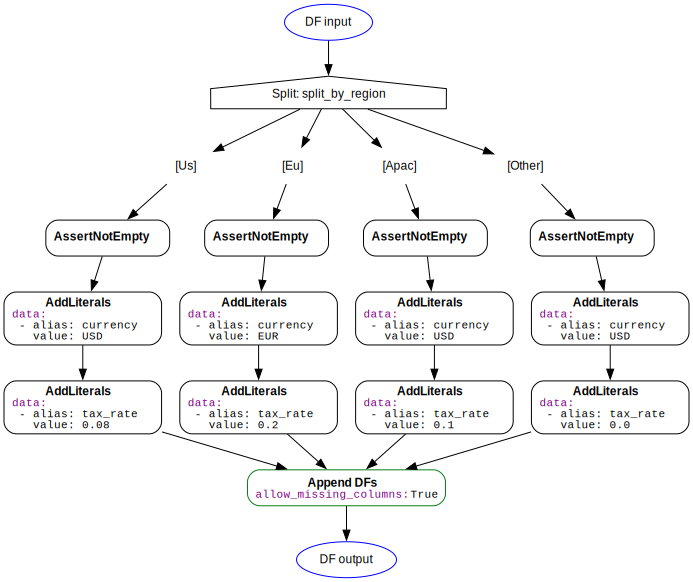

In [19]:
regional_pipeline.plot(add_params=True)

In [20]:
result = regional_pipeline.run(regional_orders)
result.sort("order_id")

2025-12-26 00:20:36,466 | [INFO]: Starting pipeline 'Regional Order Processing' 
2025-12-26 00:20:36,468 | [INFO]: Entering split: {'splits_skip_if_empty': {'other'}} 
2025-12-26 00:20:36,484 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-26 00:20:36,485 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-26 00:20:36,486 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:36,488 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:36,489 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:36,491 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:36,492 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-26 00:20:36,493 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-26 00:20:36,494 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:36,495 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:36,495 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:20:36,496 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:20:36,497 | [INFO]: Running 'AssertNot

order_id,customer,amount,region,currency,tax_rate
i64,str,f64,str,str,f64
1,"""Alice""",150.0,"""US""","""USD""",0.08
2,"""Bob""",80.0,"""EU""","""EUR""",0.2
3,"""Charlie""",320.0,"""US""","""USD""",0.08
4,"""Diana""",45.0,"""APAC""","""USD""",0.1
5,"""Eve""",200.0,"""EU""","""EUR""",0.2
6,"""Frank""",95.0,"""APAC""","""USD""",0.1
7,"""Grace""",180.0,"""US""","""USD""",0.08
8,"""Henry""",60.0,"""EU""","""EUR""",0.2
9,"""Ivy""",400.0,"""APAC""","""USD""",0.1


## Summary

Split pipelines enable **parallel processing branches** with automatic merging:

| Component | Description |
|-----------|-------------|
| `split_function` | Divides dataframe into named subsets |
| Pipeline dict | Maps split names to transformer lists |
| Merge | Automatic vertical concatenation (union) |

**Key options:**
- `split_order` — Control execution sequence
- `split_apply_after_splitting` — Common pre-processing for all splits
- `split_apply_before_appending` — Common post-processing before merge
- `splits_no_merge` — Dead-end splits (excluded from output)
- `splits_skip_if_empty` — Skip empty subsets
- `cast_subsets_to_input_schema` — Ensure schema consistency
- `allow_missing_columns` — Handle different output columns

**Next notebooks:**
- **Branching & Row Operations** — `branch`, `apply_to_rows`, skip options
- **Storage & Runtime Dynamics** — caching, LazyTransformer, debugging